In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import wandb
import torch.fft
import seaborn as sns
from tqdm import tqdm
from numpy.polynomial.legendre import legval
from scipy.special import comb
from scipy.special import gamma

In [2]:
print(torch.cuda.is_available())
torch.rand(1)

False


tensor([0.3047])

In [3]:
class SinActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)


class Net(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(Net,self).__init__()
        activation = nn.Tanh()
        #activation = SinActivation()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) :
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x
    

    
class CustomPINN(nn.Module):
    def __init__(self, N_input, N_output, N_hidden, activation=nn.Tanh):
        super(CustomPINN, self).__init__()
        self.activation = activation()

        # Input layer
        self.input_layer = nn.Linear(N_input, N_hidden)

        # Explicitly defined hidden layers
        self.hidden1 = nn.Linear(N_hidden, N_hidden)
        self.norm1 = nn.LayerNorm(N_hidden)

        self.hidden2 = nn.Linear(N_hidden, N_hidden)
        self.norm2 = nn.LayerNorm(N_hidden)

        self.hidden3 = nn.Linear(N_hidden, N_hidden)
        self.norm3 = nn.LayerNorm(N_hidden)

        # Output layer
        self.output_layer = nn.Linear(N_hidden, N_output)

    def forward(self, x):
        # Input to first hidden layer
        x = self.activation(self.input_layer(x))

        # Hidden layers with skip connections
        res = x
        x = self.activation(self.hidden1(x))
        x = self.norm1(x)
        x += res

        res = x
        x = self.activation(self.hidden2(x))
        x = self.norm2(x)
        x += res

        res = x
        x = self.activation(self.hidden3(x))
        x = self.norm3(x)
        x += res

        # Output layer
        x = self.output_layer(x)
        return x

In [4]:
class pdeOperator:
    def __init__(self, x = None, y = None, u = None):
        self.x = x
        self.y = y
        self.u = u

        
        
    def derivation(self, u, x , order = 1):
        for _ in range(order):
            u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True,retain_graph=True,allow_unused=True)[0]
        return u    
        
    def laplacian(self, u, x, y):
        u_x = self.derivative(u,x)
        u_xx = self.derivative(u_x,x)
        u_y = self.derivative(u,y)
        u_yy = self.derivative(u,y)
        return u_xx + u_yy
        


        

In [104]:
class PINN:
    def __init__(self, coords, f, boundary_conditions, operator , watch = False,name =None, u_exact = None,
                 input_size=2, output_size=1, hidden=100, layers=5, lr = 0.01):
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.coords = coords  # List of coordinate tensors (x, y, z, ...)
        self.f = f  # Forcing function
        self.boundary_conditions = boundary_conditions
        self.operator = operator  # Differential operator (e.g., Laplacian)
        self.exact_solution = u_exact
        self.watch = watch
        self.lr =lr
        self.model = self.build_model(input_size, output_size, hidden, layers)
        
        
        if self.watch :

            if len(coords) == 1:
                n = "1D"
            elif len(coords) == 2:
                n = "2D" 
            else :
                n= "3D" 

            if name != None :
                name = n + name
            else:
                name = n
            wandb.init(project="pinn-project", name=name , reinit=True)   
            wandb.watch(self.model)
            
        

        # Learnable weights for boundary conditions
        self.weights = [
            torch.tensor(1.0, requires_grad=True, device=self.device)
            for _ in range(len(boundary_conditions))
        ]

        self.optimizer = torch.optim.Adam(
            [{'params': self.model.parameters()}, {'params': self.weights}], lr=self.lr
        )
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.9)

    def build_model(self, input_size, output_size, hidden, layers):
        model = Net(input_size, output_size, hidden, layers).to(self.device)
        return model

    def derivation(self, u, x, order=1):
        for _ in range(order):
            u = torch.autograd.grad(
                u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True, allow_unused=True)[0]
        return u

    def generalized_laplacian(self, u, coords):
        """Generalized Laplacian for 1D, 2D, and 3D"""
        laplacian = 0
        for coord in coords:
            laplacian += self.derivation(self.derivation(u, coord), coord)
        return laplacian


    
    def P_k(self ,x, k):
        # Generate Legendre polynomial P_k(x)
        coeffs = [0] * (k + 1)
        coeffs[-1] = 1
        Pk = legval(x, coeffs)
        return Pk

    def v(self, x, k):
        P_k_plus = self.P_k(x, k + 1)
        P_k_minus = self.P_k(x, k - 1)
        v_k = P_k_plus - P_k_minus
        return v_k

    def simpsons_rule(self,f, x):
        # Compute the integral of f(x) using Simpson's rule
        N = x.size(0) - 1
        h = (x[-1] - x[0]) / N
        integral = h / 3 * (f[0] + f[-1] + 4 * f[1::2].sum() + 2 * f[2:-1:2].sum())
        return integral
        

    def boundary_loss(self, u_pred, bc):
        """
        Compute the boundary loss for 1D and 2D cases based on boundary conditions.

        Args:
            u_pred (torch.Tensor): Predicted solution tensor.
            bc (dict): Boundary condition containing:
                - 'type' (str): Type of boundary ('Dirichlet' or 'Neumann').
                - 'location' (str): Boundary location ('x_min', 'y_max', etc.).
                - 'value' (torch.Tensor): Expected value or derivative at the boundary.

        Returns:
            torch.Tensor: Boundary loss.
        """
        bc_type = bc['type']
        bc_location = bc['location']
        value = bc['value']

        if u_pred.ndim == 1:  # For 1D problems
            if bc_location == "x_max":
                boundary_values = u_pred[-1]
            elif bc_location == "x_min":
                boundary_values = u_pred[0]
            else:
                raise ValueError(f"Unsupported 1D boundary location: {bc_location}")
        elif u_pred.ndim == 2:  # For 2D problems
            if bc_location == "y_max":
                boundary_values = u_pred[:, -1]
            elif bc_location == "y_min":
                boundary_values = u_pred[:, 0]
            elif bc_location == "x_min":
                boundary_values = u_pred[0, :]
            elif bc_location == "x_max":
                boundary_values = u_pred[-1, :]
            else:
                raise ValueError(f"Unsupported 2D boundary location: {bc_location}")

        elif u_pred.ndim == 3:  # For 3D problems
            if bc_location == "x_min":
                boundary_values = u_pred[0, :, :]  # Slice along x_min
            elif bc_location == "x_max":
                boundary_values = u_pred[-1, :, :]  # Slice along x_max
            elif bc_location == "y_min":
                boundary_values = u_pred[:, 0, :]  # Slice along y_min
            elif bc_location == "y_max":
                boundary_values = u_pred[:, -1, :]  # Slice along y_max
            elif bc_location == "z_min":
                boundary_values = u_pred[:, :, 0]  # Slice along z_min
            elif bc_location == "z_max":
                boundary_values = u_pred[:, :, -1]  # Slice along z_max
            else:
                raise ValueError(f"Unsupported 3D boundary location: {bc_location}")

        if bc_type == 'Dirichlet':
            # Enforce Dirichlet condition: u = value
            return F.mse_loss(boundary_values, value)

        elif bc_type == 'Neumann':
            # Enforce Neumann condition: \u2202u/\u2202n = value (requires derivative calculation)
            raise NotImplementedError("Neumann boundary condition is not implemented yet.")

        else:
            raise ValueError(f"Unsupported boundary condition type: {bc_type}") 
        
    def V_loss(self, u_pred, coords, f , degree = 8):
        if len(coords) > 1:
            raise NotImplementedError("Variational loss is only implemented for 1D problems.")
        # Compute PDE loss
        f_pred = self.operator(u_pred, *coords)
        variational_loss = sum([self.simpsons_rule(((f_pred - f) * self.v(coords[0],k))**2, coords[0].squeeze()) for k in range(1,degree+1) ])/degree
        return variational_loss
    
    def sotmax_weights(self, weight):

        return torch.exp(-weight) / sum([torch.exp(-w) for w in self.weights])


    
    def compute_loss(self, u_pred, coords, f, boundary_conditions, adaptive_weights, V_loss = False):
        # PDE Loss
        f_pred = self.operator(u_pred, *coords)
        if V_loss:
            pde_loss = self.V_loss(u_pred, coords, f)
        else:
            pde_loss = torch.mean((f_pred.squeeze() - f.squeeze()) ** 2)

        # Boundary Losses
        boundary_losses = [self.boundary_loss(u_pred, bc) for bc in boundary_conditions]

        # Weighted Loss Calculation
        if not adaptive_weights:
            total_loss = pde_loss + sum(boundary_losses)
        else:
            loss =sum(boundary_losses[i] * self.sotmax_weights(self.weights[i]) for i in range(0,len(boundary_losses))) #sum(boundary_losses[i] * torch.exp(-self.weights[i]) for i in range(0,len(boundary_losses))) 
            total_loss = (
                pde_loss
                )
                #+ sum(torch.abs(w) ** 2 for w in self.weights) 
            

        if self.watch:
            wandb.log({"loss": total_loss.item(), "pde_loss": pde_loss.item()})
            for i, bc_loss in enumerate(boundary_losses):
                wandb.log({f"boundary_loss_{i}": bc_loss.item()})
            for i, weight in enumerate(self.weights):
                wandb.log({f"weight_{i}":torch.exp(-weight) })

        return total_loss

    def train(self, epochs=500, adaptive_weights=False, adaptive_collocation=False, rate=100 , V_loss = False , loss_function = None):
        coords = self.coords
        inputs = torch.cat([coord.unsqueeze(-1) for coord in coords], dim=-1) #if isinstance(coords, list) else coords.unsqueeze(-1)
        
        progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")


        for epoch in progress_bar:
            self.optimizer.zero_grad()
            u_pred = self.model(inputs).squeeze()
            if self.exact_solution is not None:
                u_exact = self.exact_solution(*coords)
            else:
                u_exact = None

            f = self.f(*coords ,u_exact)
            if loss_function is not None:
                loss = loss_function(u_pred, coords, f, self.boundary_conditions)
            else:
                loss = self.compute_loss(u_pred, coords,self.f(*coords ,u_exact) , self.boundary_conditions, adaptive_weights, V_loss)

            if V_loss and adaptive_collocation:
                raise ValueError("Adaptive collocation is not supported for variational loss.")

            if adaptive_collocation and (epoch + 1) % rate == 0:
                coords = self.update_collocation_points(coords, u_pred , u_exact)
                inputs = torch.cat([coord.unsqueeze(-1) for coord in coords], dim=-1)


            loss.backward(retain_graph=True)
            self.optimizer.step()
            self.scheduler.step()


                
            if self.exact_solution != None :
                mse = self.test()
                if self.watch  : 
                    wandb.log({ "MSE": mse.item()})
                progress_bar.set_postfix({
                "Loss": f"{loss.item()}",
                "MSE": f"{mse.item()}" if mse is not None else "N/A"
                })
            else:
                progress_bar.set_postfix({"Loss": f"{loss.item()}"})

        wandb.finish()
        if self.exact_solution != None:
            return mse.item() , loss.item()
        else:
            return 0 , loss.item()
            
    def adaptive_collocation_points(self, coords, u_pred , u_exact , num_samples = 100):
        """Adaptive collocation point update for generalized dimensions"""
        residuals = torch.abs(self.operator(u_pred, *coords).squeeze() - self.f(*coords ,u_exact).squeeze())
        p = (residuals **2) / torch.sum(residuals **2)
        indices = torch.multinomial(p.flatten(), num_samples=num_samples, replacement=True)

        new_coords = []
        for coord in coords:
            new_coord = coord.flatten()[indices].unsqueeze(1)
            new_coords.append(new_coord.squeeze())
        return new_coords
    
    def update_collocation_points(self, coords, outputs,u_exact):
        """
        Generalized update function for 1D, 2D, and 3D cases.

        Args:
            coords (list of torch.Tensor): List of coordinate tensors (e.g., [x], [x, y], or [x, y, z]).
            outputs (torch.Tensor): Model outputs at the current collocation points.

        Returns:
            list of torch.Tensor: Updated coordinates for collocation points.
        """
        # Apply adaptive collocation point selection
        adaptive_coords = self.adaptive_collocation_points(coords, outputs, u_exact)
        

        # Update each dimension's collocation points
        if len(coords) == 1: 
            adaptive_x = self.adaptive_collocation_points(coords, outputs, u_exact ,num_samples =10)[0]
            x = coords[0] 
            x = torch.cat([x, adaptive_x])
            
        elif len(coords) == 2:
            adaptive_x ,adaptive_y  = self.adaptive_collocation_points(coords, outputs, u_exact)
            x ,y = coords[0], coords[1] 
            x = torch.cat([x[:,0], adaptive_x.reshape(10, 10)[:,0]])
            y = torch.cat([y[0,:], adaptive_y.reshape(10, 10)[0,:]])
            x, y = torch.sort(x)[0], torch.sort(y)[0]
            x,y = torch.meshgrid(x,y)

        elif len(coords) == 3:
            adaptive_x, adaptive_y, adaptive_z = self.adaptive_collocation_points(coords, outputs, u_exact , num_samples = 1000)
            x, y, z = coords[0], coords[1], coords[2]
            x = torch.cat([x[:, 0, 0], adaptive_x.reshape(10, 10, 10)[:, 0, 0]])
            y = torch.cat([y[0, :, 0], adaptive_y.reshape(10, 10, 10)[0, :, 0]])
            z = torch.cat([z[0, 0, :], adaptive_z.reshape(10, 10, 10)[0, 0, :]])
            x, y, z = torch.sort(x)[0], torch.sort(y)[0], torch.sort(z)[0]
            x, y, z = torch.meshgrid(x, y, z)

        # Compute the exact solution and update f and boundary conditions
        if self.exact_solution is not None:
            if len(coords)==1:
                coords[0] = x
                u_exact = self.exact_solution(x)
            elif len(coords) == 2 :
                u_exact = self.exact_solution(x,y)
                coords[0] = x
                coords[1] = y
            elif len(coords) == 3:
                u_exact = self.exact_solution(x, y, z)
                coords[0] = x
                coords[1] = y
                coords[2] = z
    
            # Update boundary conditions

            self.boundary_conditions = self._generate_boundary_conditions(u_exact, coords)

        return coords

    def _generate_boundary_conditions(self, u_exact, coords):
        """
        Generate boundary conditions dynamically based on dimensions.
        """
        boundary_conditions = []

        if len(coords) == 1:  # 1D case
            boundary_conditions = [
                {'type': 'Dirichlet', 'location': 'x_min', 'value': u_exact[0]},
                {'type': 'Dirichlet', 'location': 'x_max', 'value': u_exact[-1]},
            ]
        elif len(coords) == 2:  # 2D case
            boundary_conditions = [
                {'type': 'Dirichlet', 'location': 'y_max', 'value': u_exact[:, -1]},
                {'type': 'Dirichlet', 'location': 'y_min', 'value': u_exact[:, 0]},
                {'type': 'Dirichlet', 'location': 'x_min', 'value': u_exact[0, :]},
                {'type': 'Dirichlet', 'location': 'x_max', 'value': u_exact[-1, :]},
            ]
        elif len(coords) == 3:  # 3D case
            boundary_conditions = [
                {'type': 'Dirichlet', 'location': 'x_min', 'value': u_exact[0, :, :]},
                {'type': 'Dirichlet', 'location': 'x_max', 'value': u_exact[-1, :, :]},
                {'type': 'Dirichlet', 'location': 'y_min', 'value': u_exact[:, 0, :]},
                {'type': 'Dirichlet', 'location': 'y_max', 'value': u_exact[:, -1, :]},
                {'type': 'Dirichlet', 'location': 'z_min', 'value': u_exact[:, :, 0]},
                {'type': 'Dirichlet', 'location': 'z_max', 'value': u_exact[:, :, -1]},
            ]

        return boundary_conditions


    def plot_solution(self, coords, u_exact):
        """Plot predictions and exact solution for 1D, 2D, or 3D"""
        inputs = torch.cat([coord.unsqueeze(-1) for coord in coords], dim=-1)
        u_pred = self.model(inputs).cpu().detach().numpy().squeeze()

        if len(coords) == 1:  # 1D case
            plt.plot(coords[0].cpu().detach().numpy().squeeze(), u_pred, label="Prediction" , linestyle = "--")
            if u_exact is not None:
                plt.plot(coords[0].cpu().detach().numpy().squeeze(), u_exact.cpu().detach().numpy().squeeze(), label="Exact")
            plt.legend()
            plt.show()
        elif len(coords) == 2:  # 2D case
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            axes[0].contourf(coords[0].cpu().detach().numpy(), coords[1].cpu().detach().numpy(), u_pred,levels = 100, cmap="jet")
            axes[0].set_title("Prediction")
            axes[1].contourf(coords[0].cpu().detach().numpy(), coords[1].cpu().detach().numpy(),
                             u_exact.cpu().detach().numpy(),levels = 100, cmap="jet")
            axes[1].set_title("Exact")
            plt.show()
        elif len(coords) == 3:  # 3D case

            x_test, y_test, z_test = [coord.cpu().detach().numpy().squeeze() for coord in coords]
            inputs = torch.cat([coord.unsqueeze(-1) for coord in coords], dim=-1)
            prediction = self.model(inputs).cpu().detach().numpy().squeeze()

            slice_idx = prediction.shape[2] // 2
            x_slice = x_test[:, :, slice_idx]
            y_slice = y_test[:, :, slice_idx]
            u_slice = prediction[:, :, slice_idx]
            u_exact_slice = u_exact.cpu().detach().numpy()[:, :, slice_idx]
            # Plot the 2D slices in 3D side by side
            fig = plt.figure(figsize=(20, 7))  # Adjust figure size for better visibility

            # Create two subplots side by side with 3D projection
            ax1 = fig.add_subplot(1, 2, 1, projection='3d')  # First subplot
            ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Second subplot

            # First plot: Predicted Solution Slice
            surf1 = ax1.plot_surface(x_slice, y_slice, u_slice, cmap="viridis")
            ax1.set_title("Predicted Solution Slice at z=middle")
            ax1.set_xlabel("X")
            ax1.set_ylabel("Y")
            ax1.set_zlabel("Prediction (u)")
            fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=12)

            # Second plot: Exact Solution Slice
            surf2 = ax2.plot_surface(x_slice, y_slice, u_exact_slice, cmap="viridis")
            ax2.set_title("Exact Solution Slice at z=middle")
            ax2.set_xlabel("X")
            ax2.set_ylabel("Y")
            ax2.set_zlabel("Exact (u)")
            fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=12)

            plt.tight_layout()
            plt.show()

            



    def test(self):
        

        dimensions = len(self.coords)   

        if dimensions == 1:
            a = torch.linspace(-1 , 1 , 100).unsqueeze(-1).to(self.device)
            coords = [a]
            inputs = a
        elif dimensions == 2:
            a = torch.linspace(-1 , 1 , 100).to(self.device)
            b = torch.linspace(-1 , 1 , 100).to(self.device)
            a, b = torch.meshgrid(a, b)
            coords = [a, b]
            inputs = torch.cat([coord.unsqueeze(-1) for coord in [a, b]], dim=-1)
        elif dimensions == 3:
            a = torch.linspace(-1 , 1 , 10).to(self.device)
            b = torch.linspace(-1 , 1 , 10).to(self.device)
            c = torch.linspace(-1 , 1 , 10).to(self.device)
            a, b, c = torch.meshgrid(a, b, c)
            coords = [a, b, c]
            inputs = torch.cat([coord.unsqueeze(-1) for coord in [a, b, c]], dim=-1)
        u_test = self.model(inputs).squeeze()

        mse = F.mse_loss(u_test, self.exact_solution(*coords))
        return mse
    


In [38]:
class Solver:
    def __init__(self):
        """
        Initialize a Solver instance. 
        This constructor does not store PDE parameters or training configurations.
        These should be provided to the solve method.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def solve(
        self,
        domaine,
        operator=None, 
        source_function=None, 
        u_exact=None, 
        epochs=1001, 
        adaptive_weights=False, 
        adaptive_collocation=False,
        dimensions=None, 
        num_points=50, 
        rate=250, 
        hidden=100, 
        layers=1, 
        watch=False,
        name=None,
        lr=0.01, 
        V_loss=False, 
        plot=True, 
        n_test=10,
    ):
        """
        Solve the PDE for the given domain and configuration.

        Parameters
        ----------
        domaine : list or tuple
            Domain definition. For 1D: [a,b], 2D: [a,b,c,d], 3D: [a,b,c,d,e,f].
        operator : callable, optional
            PDE operator function.
        source_function : callable, optional
            Source term of the PDE.
        u_exact : callable, optional
            Exact solution for reference.
        epochs : int, default=1001
            Number of training epochs.
        adaptive_weights : bool, default=False
            Use adaptive weighting for PDE and BC loss terms.
        adaptive_collocation : bool, default=False
            Use adaptive collocation point selection.
        dimensions : int, optional
            Dimensionality of the problem (1, 2, or 3).
        num_points : int, default=50
            Number of collocation points.
        rate : int, default=250
            Rate at which adaptive strategies update.
        hidden : int, default=100
            Number of hidden units per layer in the NN.
        layers : int, default=1
            Number of hidden layers in the NN.
        watch : bool, default=False
            If True, enable logging with external tools (e.g., wandb).
        lr : float, default=0.01
            Learning rate.
        V_loss : bool, default=False
            If True, use variational loss formulation.
        plot : bool, default=True
            If True, plot solutions after training.
        n_test : int, default=10
            Number of test points for plotting or evaluation.

        Returns
        -------
        D : PINN object
            Trained neural network model.
        """
        if dimensions == 1:
            return self._solve_1D(
                domaine, operator, source_function, u_exact,
                epochs, adaptive_weights, adaptive_collocation, 
                num_points, rate, hidden, layers, watch,name, lr, V_loss, plot, n_test
            )
        elif dimensions == 2:
            return self._solve_2D(
                domaine, operator, source_function, u_exact,
                epochs, adaptive_weights, adaptive_collocation, 
                num_points, rate, hidden, layers, watch,name , lr, V_loss, plot, n_test
            )
        elif dimensions == 3:
            return self._solve_3D(
                domaine, operator, source_function, u_exact,
                epochs, adaptive_weights, adaptive_collocation, 
                num_points, rate, hidden, layers, watch,name, lr, V_loss, plot, n_test
            )
        else:
            raise ValueError(f"Unsupported dimensions: {dimensions}")

    def _solve_1D(self, domaine, operator, source_function, u_exact, epochs, adaptive_weights, 
                  adaptive_collocation, num_points, rate, hidden, layers, watch, name , lr, V_loss, plot, n_test):
        if len(domaine) != 2:
            raise ValueError("1D domain must have exactly 2 points.")
        a, b = domaine

        if not V_loss:
            x = a + (b - a) * torch.rand(num_points, requires_grad=True).to(self.device)
            x = torch.sort(x)[0]
        else:
            x = torch.linspace(a, b, num_points, requires_grad=True).to(self.device)

        u = u_exact(x)

        boundary_conditions = [
            {'type': 'Dirichlet', 'location': 'x_max', 'value': u[-1]},
            {'type': 'Dirichlet', 'location': 'x_min', 'value': u[0]},
        ]

        f = lambda x, u: source_function(x).squeeze()

        

        

        D = PINN(
            [x], f, boundary_conditions, operator, u_exact=u_exact,
            input_size=1, output_size=1, hidden=hidden, layers=layers,
            watch=watch, name = name, lr=lr
        )
        mse , loss = D.train(
            epochs=epochs, adaptive_weights=adaptive_weights,
            adaptive_collocation=adaptive_collocation, rate=rate, V_loss=V_loss
        )

        model = D.model

        if plot:
            if not V_loss:
                x_test = a + (b - a) * torch.rand(n_test, requires_grad=True).to(self.device)
                x_test = torch.sort(x_test)[0]
            else:
                x_test = torch.linspace(a, b, n_test, requires_grad=True).to(self.device)
            D.plot_solution([x_test], u_exact(x_test))
        return model ,mse , loss

    def _solve_2D(self, domaine, operator, source_function, u_exact, epochs, adaptive_weights, 
                  adaptive_collocation, num_points, rate, hidden, layers, watch, name , lr, V_loss, plot, n_test):
        if len(domaine) != 4:
            raise ValueError("2D domain must have exactly 4 points.")
        a, b, c, d = domaine

        x = a + (b - a) * torch.rand(num_points, requires_grad=True).to(self.device)
        y = c + (d - c) * torch.rand(num_points, requires_grad=True).to(self.device)
        x, y = torch.sort(x)[0], torch.sort(y)[0]
        x, y = torch.meshgrid(x, y)

        u_exact_local = lambda X, Y: X**2 + Y**2
        u = u_exact_local(x, y)

        boundary_conditions = [
            {'type': 'Dirichlet', 'location': 'y_max', 'value': u[:, -1]},
            {'type': 'Dirichlet', 'location': 'y_min', 'value': u[:, 0]},
            {'type': 'Dirichlet', 'location': 'x_min', 'value': u[0, :]},
            {'type': 'Dirichlet', 'location': 'x_max', 'value': u[-1, :]},
        ]

        op = pdeOperator(x, y, u)
        f = lambda X, Y, U: source_function(X, Y).squeeze()



        D = PINN(
            [x, y], f, boundary_conditions, operator, u_exact=u_exact,
            input_size=2, output_size=1, hidden=hidden, layers=layers,
            watch=watch, name = name, lr=lr
        )
        mse , loss = D.train(
            epochs=epochs, adaptive_weights=adaptive_weights,
            adaptive_collocation=adaptive_collocation, rate=rate
        )

        model = D.model

        if plot:
            x_test = a + (b - a) * torch.rand(n_test, requires_grad=True).to(self.device)
            y_test = c + (d - c) * torch.rand(n_test, requires_grad=True).to(self.device)
            x_test, y_test = torch.sort(x_test)[0], torch.sort(y_test)[0]
            x_test, y_test = torch.meshgrid(x_test, y_test)
            D.plot_solution([x_test, y_test], u_exact_local(x_test, y_test))
        return model ,mse , loss

    def _solve_3D(self, domaine, operator, source_function, u_exact, epochs, adaptive_weights, 
                  adaptive_collocation, num_points, rate, hidden, layers, watch,name, lr, V_loss, plot, n_test):
        if len(domaine) != 6:
            raise ValueError("3D domain must have exactly 6 points.")
        a, b, c, d, e, f_ = domaine

        x = a + (b - a) * torch.rand(num_points, requires_grad=True).to(self.device)
        y = c + (d - c) * torch.rand(num_points, requires_grad=True).to(self.device)
        z = e + (f_ - e) * torch.rand(num_points, requires_grad=True).to(self.device)
        x, y, z = torch.sort(x)[0], torch.sort(y)[0], torch.sort(z)[0]
        x, y, z = torch.meshgrid(x, y, z)

        u_exact_local = lambda X, Y, Z: torch.sin(torch.pi * X) * torch.sin(torch.pi * Y) * torch.sin(torch.pi * Z)
        u = u_exact_local(x, y, z)

        boundary_conditions = [
            {'type': 'Dirichlet', 'location': 'x_min', 'value': u[0, :, :]},
            {'type': 'Dirichlet', 'location': 'x_max', 'value': u[-1, :, :]},
            {'type': 'Dirichlet', 'location': 'y_min', 'value': u[:, 0, :]},
            {'type': 'Dirichlet', 'location': 'y_max', 'value': u[:, -1, :]},
            {'type': 'Dirichlet', 'location': 'z_min', 'value': u[:, :, 0]},
            {'type': 'Dirichlet', 'location': 'z_max', 'value': u[:, :, -1]},
        ]

        op = pdeOperator(x, y, z)
        func = lambda X, Y, Z, U: source_function(X, Y, Z).squeeze()

        D = PINN(
            [x, y, z], func, boundary_conditions, operator, u_exact=u_exact,
            input_size=3, output_size=1, hidden=hidden, layers=layers,
            watch=watch, name = name , lr=lr
        )
        mse , loss = D.train(
            epochs=epochs, adaptive_weights=adaptive_weights,
            adaptive_collocation=adaptive_collocation, rate=rate
        )

        model = D.model

        if plot:
            x_test = a + (b - a) * torch.rand(n_test, requires_grad=True).to(self.device)
            y_test = c + (d - c) * torch.rand(n_test, requires_grad=True).to(self.device)
            z_test = e + (f_ - e) * torch.rand(n_test, requires_grad=True).to(self.device)
            x_test, y_test, z_test = torch.sort(x_test)[0], torch.sort(y_test)[0], torch.sort(z_test)[0]
            x_test, y_test, z_test = torch.meshgrid(x_test, y_test, z_test)
            D.plot_solution([x_test, y_test, z_test], u_exact_local(x_test, y_test, z_test))
        return model, mse , loss


    def Benchmark(
        self,
        domaine,
        operator=None, 
        source_function=None, 
        u_exact=None, 
        epochs=1001, 
        dimensions=None, 
        num_points=50, 
        rate=250, 
        hidden=100, 
        layers=1, 
        watch=False, 
        lr=0.01, 
        plot=True, 
        n_test=10
    ):
        """
        Benchmark various PINN configurations (e.g., with and without adaptive weighting/collocation,
        variational loss, etc.) across different PDE dimensions.

        Parameters
        ----------
        domaine : list or tuple
            Domain definition for the PDE.
        operator : callable, optional
            PDE operator function.
        source_function : callable, optional
            Source term of the PDE.
        u_exact : callable, optional
            Exact solution for reference.
        epochs : int, default=1001
            Number of training epochs.
        dimensions : int, optional
            PDE dimensionality (1, 2, or 3).
        num_points : int, default=50
            Number of collocation points.
        rate : int, default=250
            Rate for adaptive strategies.
        hidden : int, default=100
            Number of hidden units per layer.
        layers : int, default=1
            Number of hidden layers.
        watch : bool, default=False
            If True, enable logging (e.g., wandb).
        lr : float, default=0.01
            Learning rate.
        plot : bool, default=True
            If True, plot solutions after training.
        n_test : int, default=10
            Number of test points for evaluation/plotting.

        Returns
        -------
        (Models_names, Models) : (list of str, list of models)
            Models_names is a list of model configuration names.
            Models is a list of the trained models corresponding to each configuration.
        """
        if dimensions is None:
            raise ValueError("dimensions must be specified (1, 2, or 3).")

        # Define model configurations based on dimensions
        # Each entry: (name, adaptive_weights, adaptive_collocation, V_loss)
        # The indexes are for explanation; the sets differ by dimension.
        if dimensions == 1:
            model_configs = [
                ("PINN",       False, False, False),
                ("AC-PINN",    False, True,  False),
                ("AW-PINN",    True,  False, False),
                ("ACAW-PINN",  True,  True,  False),
                ("V-PINN",     False, False, True),
                ("AW-VPINN",   True,  False, True),
            ]
            dim_str = "1D"
        elif dimensions == 2:
            model_configs = [
                ("PINN",      False, False, False),
                ("AC-PINN",   False, True,  False),
                ("AW-PINN",   True,  False, False),
                ("ACAW-PINN", True,  True,  False),
            ]
            dim_str = "2D"
        elif dimensions == 3:
            # If 3D supports V-PINN or others, adjust accordingly.
            # Assuming similar to 1D with V-PINN variants:
            model_configs = [
                ("PINN",      False, False, False),
                ("AC-PINN",   False, True,  False),
                ("AW-PINN",   True,  False, False),
                ("ACAW-PINN", True,  True,  False),
                # Add V-PINN variants if needed:
                # ("V-PINN",     False, False, True),
                # ("AW-VPINN",   True,  False, True),
            ]
            dim_str = "3D"
        else:
            raise ValueError(f"Unsupported dimensions: {dimensions}")

        print(f"Starting benchmark for {dim_str} PDE models.")
        Models_names = [cfg[0] for cfg in model_configs]
        Models = []
        MSE = []
        LOSS = []

        for name, aw, ac, vloss in model_configs:
            print(f"Training {name} ...")
            model ,mse , loss = self.solve(
                domaine=domaine,
                operator=operator,
                source_function=source_function,
                u_exact=u_exact,
                epochs=epochs,
                adaptive_weights=aw,
                adaptive_collocation=ac,
                dimensions=dimensions,
                num_points=num_points,
                rate=rate,
                hidden=hidden,
                layers=layers,
                watch=watch,
                name = name,
                lr=lr,
                V_loss=vloss,
                plot=plot,
                n_test=n_test
            )
            Models.append(model)
            MSE.append(mse)
            LOSS.append(loss)
            print(f"Finished training {name}.\n{'-'*40}")

        print(f"Benchmark for {dim_str} completed. Trained models: {Models_names}")
        return Models_names, Models


In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

d = pdeOperator()
operator = lambda u,x: d.derivation(u, x, order=2) 
f= lambda x: (-1.6 * (torch.pi**2) * torch.sin(torch.pi * x * 4) - 50 * torch.tanh(5 * x) * (1 - torch.tanh(5 * x)**2))
u_exact = lambda x:  0.1 * torch.sin(torch.pi * x * 4) + torch.tanh(5 * x)
domaine = [-1,1]


solver = Solver()

In [72]:
AW_mse = []
AW_loss = []
for i in range(5):
    model , mse , loss = solver.solve(dimensions =1 ,domaine= domaine , source_function= f , operator= operator, u_exact= u_exact , epochs = 2000 , num_points = 20, n_test = 500 , adaptive_weights = False , adaptive_collocation = False , lr = 0.01, plot = False , layers= 3 , watch = False)
    AW_mse.append(mse)
    AW_loss.append(loss)

Training: 100%|██████████| 2000/2000 [00:21<00:00, 93.28epoch/s, Loss=0.001807599444873631, MSE=0.2339741438627243]   


### Adaptive weights

In [ ]:
AW_mse = []
AW_loss = []
for i in range(5):
    model , mse , loss = solver.solve(dimensions =1 ,domaine= domaine , source_function= f , operator= operator, u_exact= u_exact , epochs = 2000 , num_points = 20, n_test = 500 , adaptive_weights = True , adaptive_collocation = False , lr = 0.01, plot = False , layers= 3 , watch = False)
    AW_mse.append(mse)
    AW_loss.append(loss)

Training:  62%|██████▏   | 1247/2000 [00:22<00:13, 56.18epoch/s, Loss=0.16227898001670837, MSE=0.09907907992601395] 


KeyboardInterrupt: 

In [47]:
print(AW_loss , AW_mse)

[0.006221962161362171, 0.00553611246868968, 0.005431223660707474, 0.00802732352167368, 0.031490009278059006, 0.005917936097830534, 0.010998839512467384, 0.004263566341251135, 0.0077372645027935505, 0.003846369218081236] [5.118263743497664e-06, 8.064753274084069e-06, 0.03871793672442436, 0.00013201998081058264, 0.06592308729887009, 3.4077372674801154e-06, 0.0033285690005868673, 0.0001604828576091677, 0.003145889611914754, 1.8366963558946736e-06]


In [ ]:

solver.solve(dimensions =1 ,domaine= domaine , source_function= f , operator= operator , epochs = 1 , num_points = 20, n_test = 500 , adaptive_weights = True , adaptive_collocation = False , lr = 0.001, plot = True , layers= 3 , watch = False  )

TypeError: 'NoneType' object is not callable

Training: 100%|██████████| 10/10 [00:00<00:00, 10.79epoch/s, Loss=104.5758056640625, MSE=0.23068355023860931]


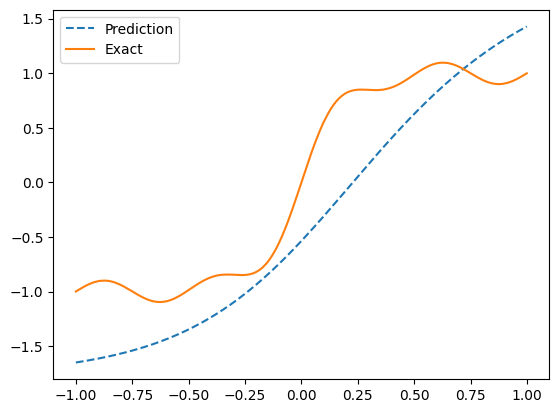

In [52]:
solver.solve(dimensions =1 ,domaine= domaine , source_function= f , operator= operator , epochs = 10 , num_points = 100, n_test = 500 , adaptive_weights = True , adaptive_collocation = True , lr = 0.001, plot = True , layers= 3 , watch = False)

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training: 100%|██████████| 100/100 [00:03<00:00, 28.97epoch/s, Loss=26.09356117248535, MSE=0.039879269897937775]


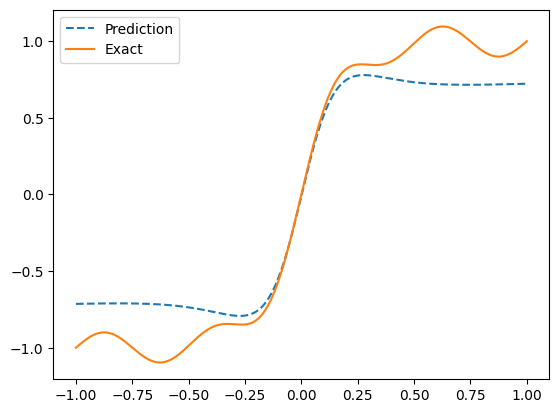

In [53]:
solver.solve(dimensions =1 ,domaine= domaine , source_function= f , operator= operator , epochs = 100 , num_points = 100, n_test = 500 , adaptive_weights = True , adaptive_collocation = False , lr = 0.001, plot = True , layers= 3 , watch = False , V_loss = True)

Training: 100%|██████████| 100/100 [00:04<00:00, 23.24epoch/s, Loss=26.4728946685791, MSE=0.07634149491786957]  


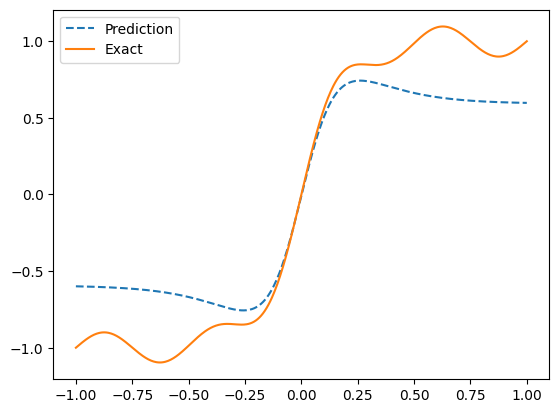

In [54]:
solver.solve(dimensions =1 ,domaine= domaine , source_function= f , operator= operator , epochs = 100 , num_points = 100, n_test = 500 , adaptive_weights = True , adaptive_collocation = False , lr = 0.001, plot = True , layers= 3 , watch = False , V_loss = True)

## 2 Dimensions

In [105]:
domaine_2d = [-1,1,-1,1]
f_2d = lambda x,y : torch.ones_like(x)*4
operator_2d = lambda u,x,y : d.derivation(u, x, order=2) + d.derivation(u, y, order=2)
u_exact_2d = lambda x,y :  x**2 + y**2
solver = Solver()
#solver.solve(dimensions =2 ,domaine= domaine_2d , source_function= f_2d , operator= operator_2d , epochs = 10 , num_points = 10, n_test = 500 , adaptive_weights = False , adaptive_collocation = False , lr = 0.001, plot = True , layers= 3 , watch = False)

In [113]:
Model = []
MSE = []
LOSS = []
for i in range(10):
    model , mse , loss = solver.solve(dimensions =2 ,domaine= domaine_2d , source_function= f_2d , operator= operator_2d, u_exact = u_exact_2d , epochs = 1000 , num_points = 20, n_test = 500 , adaptive_weights = False , adaptive_collocation = False , lr = 0.01, plot = False , layers= 3 , watch = False , rate = 100)
    Model.append(model)
    MSE.append(mse)
    LOSS.append(loss)

print(sum(MSE)/len(MSE) , sum(LOSS)/len(LOSS))

Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training: 100%|██████████| 1000/1000 [00:40<00:00, 24.84epoch/s, Loss=2.1423373254947364e-05, MSE=1.0903801239692257e-06]


2.911067170430215e-06 5.119729248690419e-05


In [114]:
Model = []
MSE = []
LOSS = []
for i in range(10):
    model , mse , loss = solver.solve(dimensions =2 ,domaine= domaine_2d , source_function= f_2d , operator= operator_2d, u_exact = u_exact_2d , epochs = 1000 , num_points = 20, n_test = 500 , adaptive_weights = True , adaptive_collocation = False , lr = 0.01, plot = False , layers= 3 , watch = False , rate = 100)
    Model.append(model)
    MSE.append(mse)
    LOSS.append(loss)

print(sum(MSE)/len(MSE) , sum(LOSS)/len(LOSS))

Training: 100%|██████████| 1000/1000 [00:37<00:00, 26.80epoch/s, Loss=1.7159143681055866e-05, MSE=29.51138687133789]

37.949239349365236 2.0901300285913748e-05


Training: 100%|██████████| 10/10 [00:00<00:00, 17.04epoch/s, Loss=7.4700822830200195, MSE=0.08656485378742218]


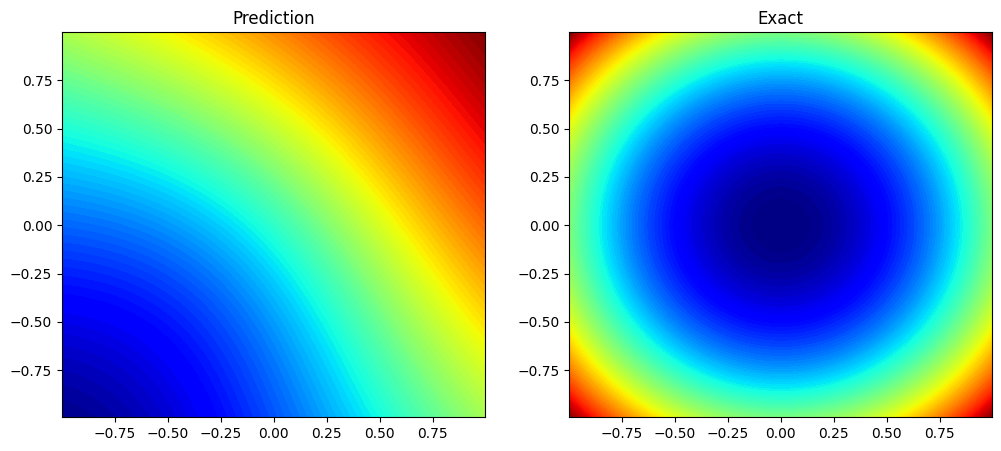

In [59]:
solver.solve(dimensions =2 ,domaine= domaine_2d , source_function= f_2d , operator= operator_2d , epochs = 10 , num_points = 10, n_test = 500 , adaptive_weights = True , adaptive_collocation = True , lr = 0.001, plot = True , layers= 3 , watch = False)

## 3 Dimensions

In [15]:
domaine_3d = [-1,1,-1,1,-1,1]
d = pdeOperator()
f_3d = lambda x,y,z : -3 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)
operator_3d = lambda u,x,y,z : d.derivation(u, x, order=2) + d.derivation(u, y, order=2) + d.derivation(u, z, order=2)

In [16]:
solver = Solver()

c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training: 100%|██████████| 10/10 [00:00<00:00, 24.18epoch/s, Loss=145.6388397216797, MSE=0.10998491197824478]


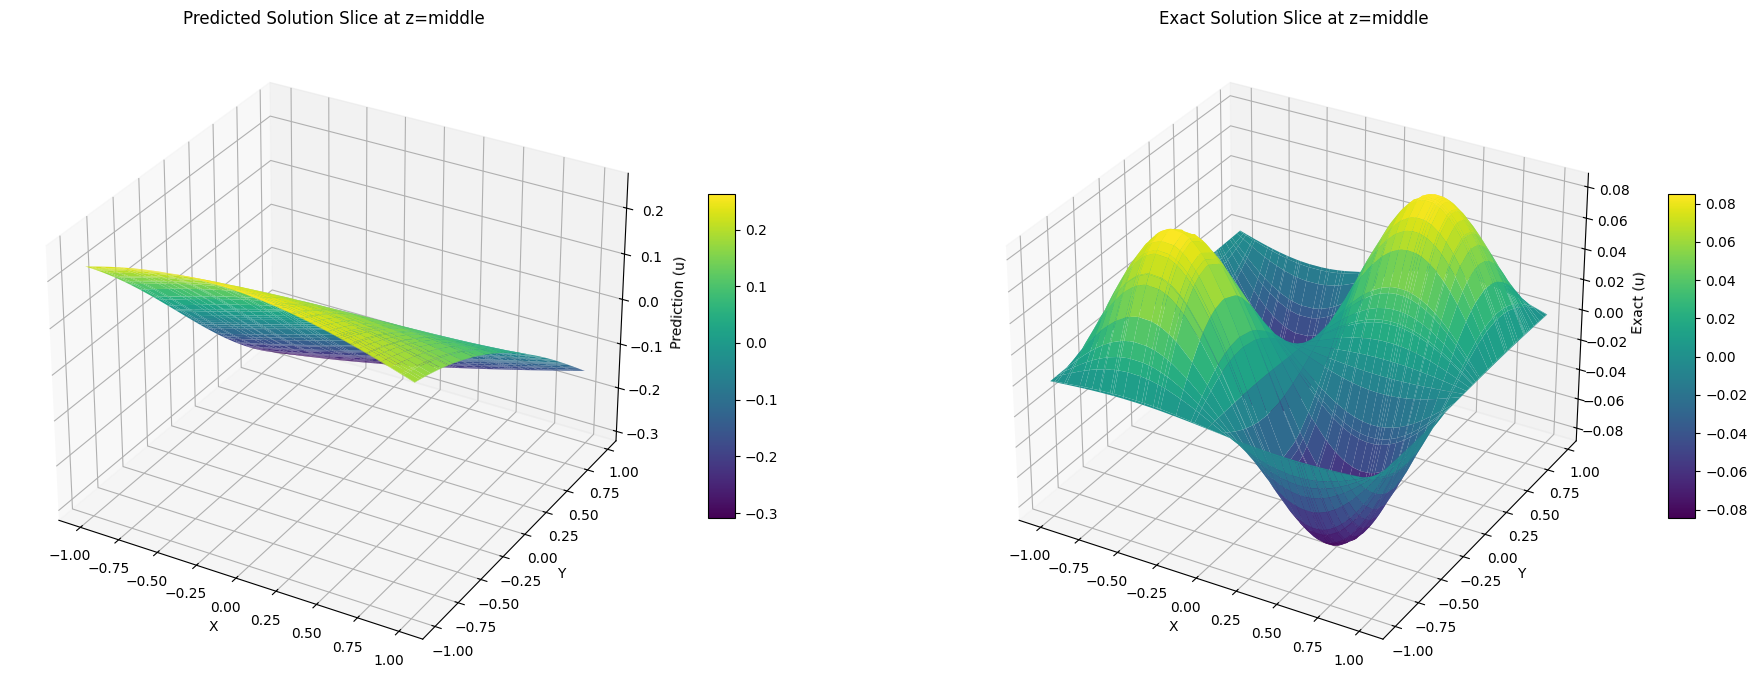

In [11]:
solver.solve(dimensions =3 ,domaine= domaine_3d , source_function= f_3d , operator= operator_3d , epochs = 10 , num_points = 10, n_test = 100 , adaptive_weights = False , adaptive_collocation = False , lr = 0.001, plot = True , layers= 3 , watch = False)

Training: 100%|██████████| 10/10 [00:00<00:00, 10.14epoch/s, Loss=70.1798324584961]


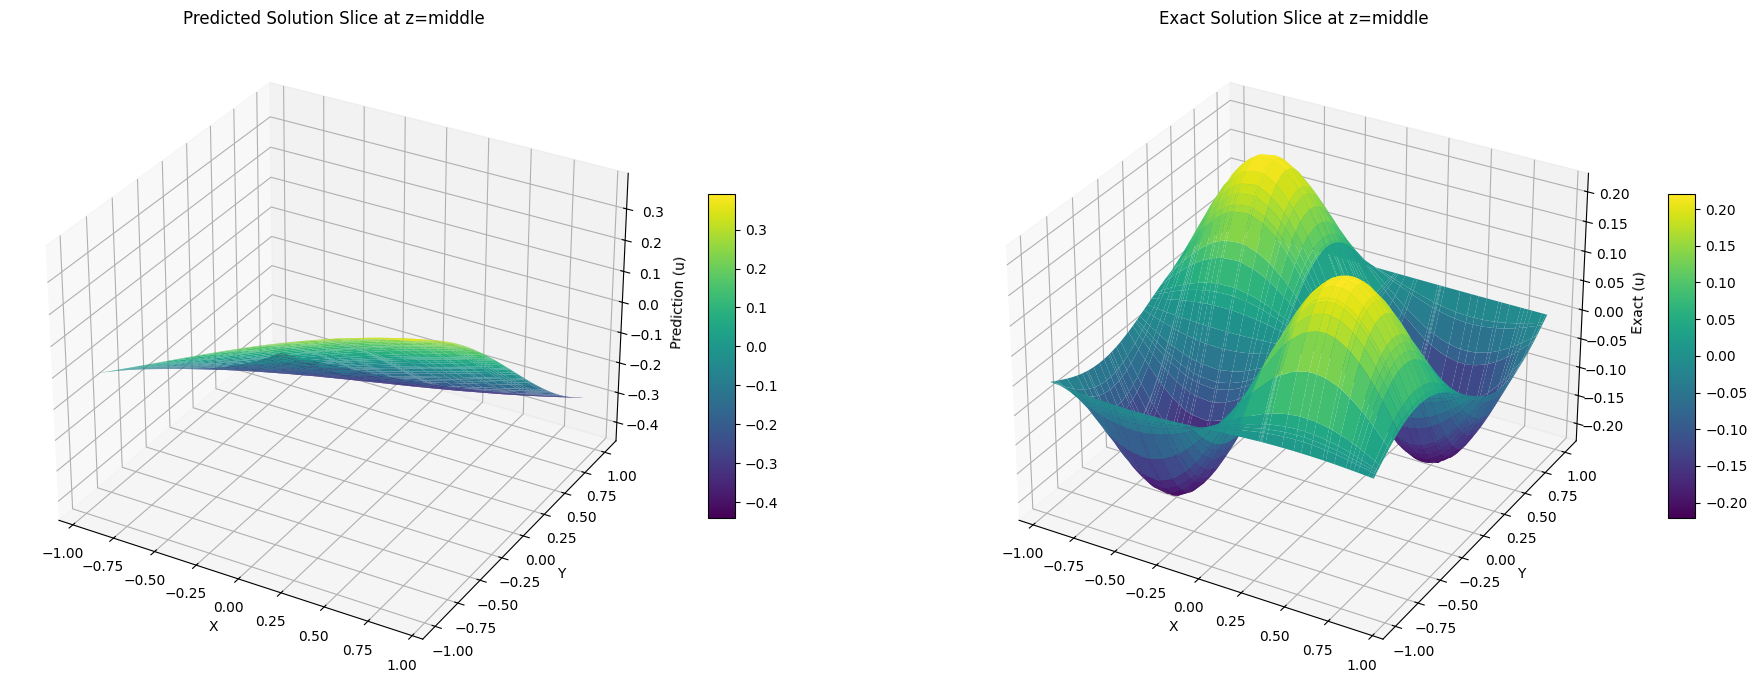

In [18]:
solver.solve(dimensions =3 ,domaine= domaine_3d , source_function= f_3d , operator= operator_3d , epochs = 10 , num_points = 10, n_test = 100 , adaptive_weights = False , adaptive_collocation = True , lr = 0.001, plot = True , layers= 3 , watch = False , rate = 5)

Training: 100%|██████████| 10/10 [00:01<00:00,  6.83epoch/s, Loss=61.03208923339844, MSE=0.23325762152671814]


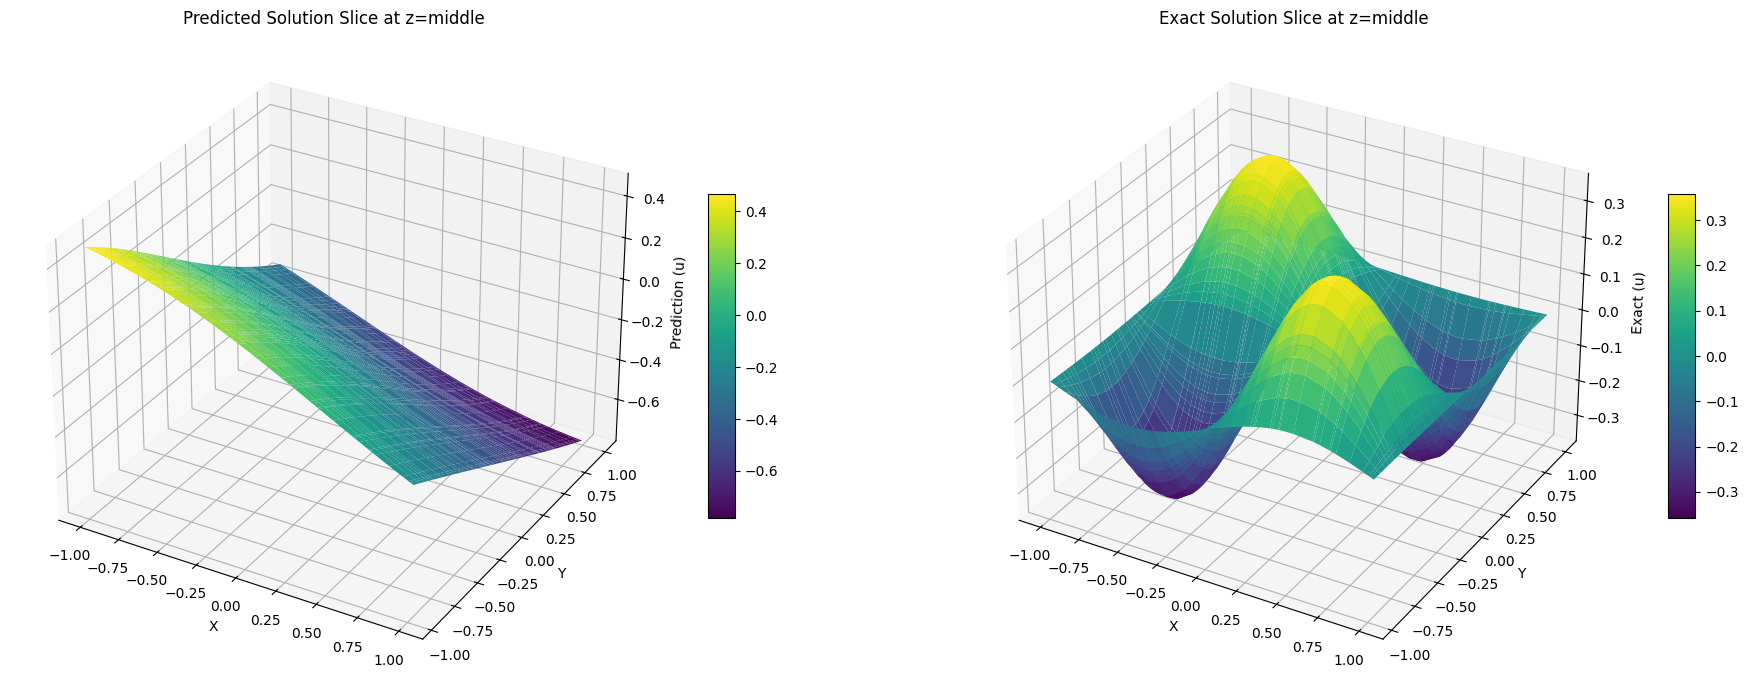

In [13]:
solver.solve(dimensions =3 ,domaine= domaine_3d , source_function= f_3d , operator= operator_3d , epochs = 10 , num_points = 10, n_test = 100 , adaptive_weights = True , adaptive_collocation = False , lr = 0.001, plot = True , layers= 3 , watch = False)

Training: 100%|██████████| 10/10 [00:01<00:00,  8.12epoch/s, Loss=80.17910766601562, MSE=0.33082422614097595]


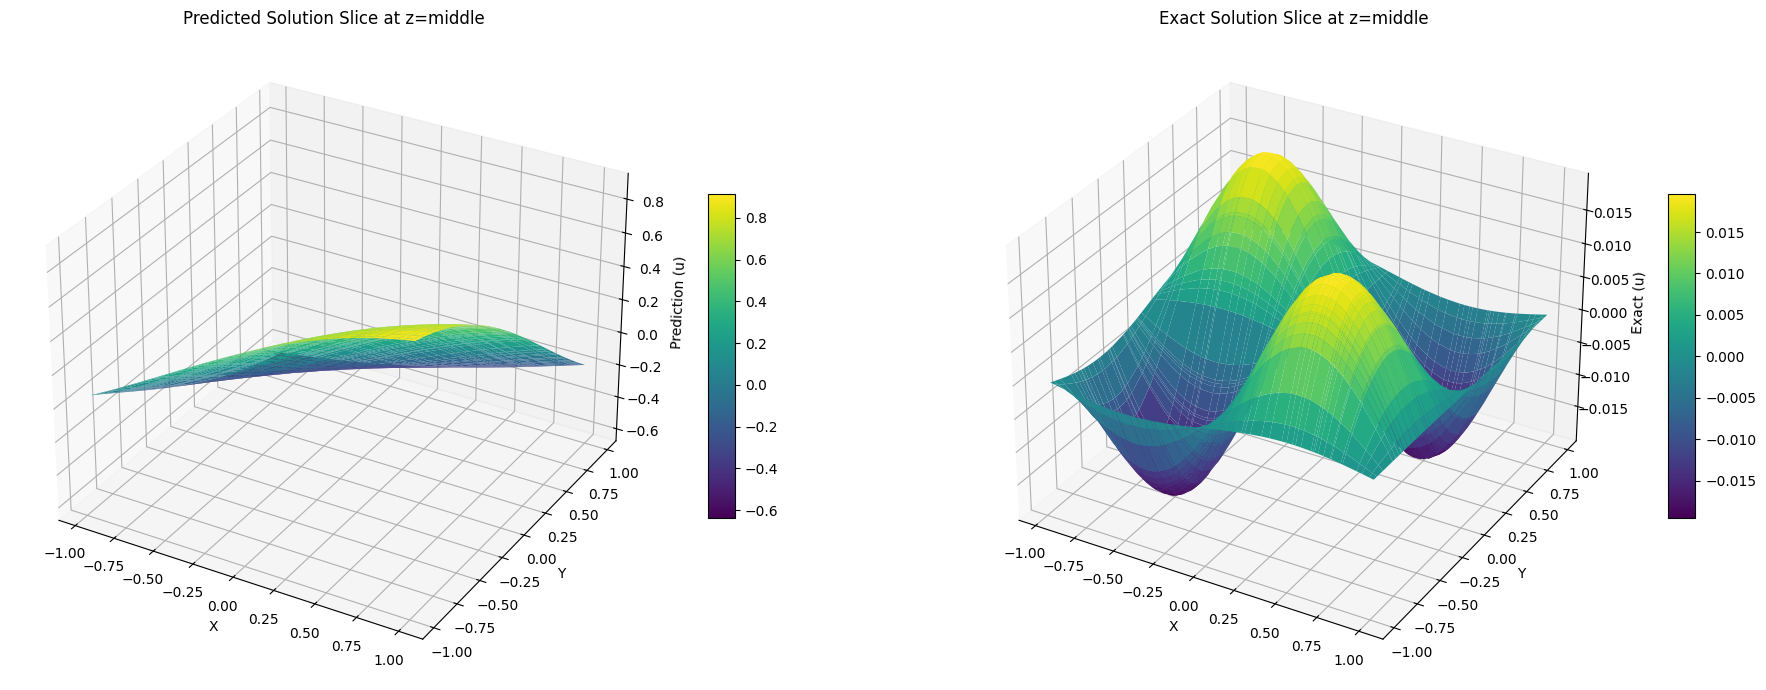

In [14]:
solver.solve(dimensions =3 ,domaine= domaine_3d , source_function= f_3d , operator= operator_3d , epochs = 10 , num_points = 10, n_test = 100 , adaptive_weights = False , adaptive_collocation = True , lr = 0.001, plot = True , layers= 3 , watch = False)

In [23]:
models, models_names = solver.Benchmark(dimensions =1 ,domaine= domaine , source_function= f , operator= operator, u_exact=u_exact , epochs = 1000 , num_points = 20 , n_test = 500 , lr = 0.001, plot = False , layers= 3 , watch = False , rate = 200)    

Starting benchmark for 1D PDE models.
Training PINN ...


Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training: 100%|██████████| 1000/1000 [00:09<00:00, 103.59epoch/s, Loss=0.0006951139657758176, MSE=0.16086088120937347]


Finished training PINN.
----------------------------------------
Training AC-PINN ...


Training: 100%|██████████| 1000/1000 [00:10<00:00, 92.17epoch/s, Loss=0.07116985321044922, MSE=0.4647200405597687]  


Finished training AC-PINN.
----------------------------------------
Training AW-PINN ...


Training: 100%|██████████| 1000/1000 [00:11<00:00, 87.85epoch/s, Loss=0.003637122455984354, MSE=0.28846225142478943]


Finished training AW-PINN.
----------------------------------------
Training ACAW-PINN ...


Training: 100%|██████████| 1000/1000 [00:12<00:00, 79.08epoch/s, Loss=0.00629434734582901, MSE=0.02172621712088585]  


Finished training ACAW-PINN.
----------------------------------------
Training V-PINN ...


Training: 100%|██████████| 1000/1000 [00:29<00:00, 34.27epoch/s, Loss=7.152583213210217e-12, MSE=0.38879257440567017]


Finished training V-PINN.
----------------------------------------
Training AW-VPINN ...


Training: 100%|██████████| 1000/1000 [00:32<00:00, 30.93epoch/s, Loss=0.005112201441079378, MSE=0.4165339469909668] 


Finished training AW-VPINN.
----------------------------------------
Benchmark for 1D completed. Trained models: ['PINN', 'AC-PINN', 'AW-PINN', 'ACAW-PINN', 'V-PINN', 'AW-VPINN']


In [37]:
domaine_2d = [-1,1,-1,1]
f_2d = lambda x,y : torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) + torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2)
operator_2d = lambda u,x,y : d.derivation(u, x, order=2) + d.derivation(u, y, order=2)
u_exact_2d = lambda x,y : x**2 + y**2
solver = Solver()

solver.Benchmark(dimensions =2 ,domaine= domaine_2d , source_function= f_2d , operator= operator_2d , u_exact = u_exact_2d , epochs = 1000 , num_points = 20 , n_test = 500 , lr = 0.01, plot = False , layers= 3 , watch = False ,rate = 500)

c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Starting benchmark for 2D PDE models.
Training PINN ...


Training: 100%|██████████| 1000/1000 [00:27<00:00, 36.09epoch/s, Loss=0.0072157722897827625, MSE=0.0275606419891119]


Finished training PINN.
----------------------------------------
Training AC-PINN ...


Training: 100%|██████████| 1000/1000 [00:36<00:00, 27.76epoch/s, Loss=0.008034438826143742, MSE=0.0340353362262249] 


Finished training AC-PINN.
----------------------------------------
Training AW-PINN ...


Training: 100%|██████████| 1000/1000 [00:28<00:00, 34.72epoch/s, Loss=0.0017535443184897304, MSE=0.6437119245529175]


Finished training AW-PINN.
----------------------------------------
Training ACAW-PINN ...


Training: 100%|██████████| 1000/1000 [00:38<00:00, 26.03epoch/s, Loss=0.010652486234903336, MSE=0.06989152729511261]

Finished training ACAW-PINN.
----------------------------------------
Benchmark for 2D completed. Trained models: ['PINN', 'AC-PINN', 'AW-PINN', 'ACAW-PINN']


(['PINN', 'AC-PINN', 'AW-PINN', 'ACAW-PINN'],
  <__main__.PINN at 0x299c845b590>])

In [39]:
domaine_3d = [-1,1,-1,1,-1,1]
f_3d = lambda x,y,z : -3 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)
operator_3d = lambda u,x,y,z : d.derivation(u, x, order=2) + d.derivation(u, y, order=2) + d.derivation(u, z, order=2)
u_exact_3d = lambda x,y,z : torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.sin(torch.pi * z)

solver.Benchmark(dimensions =3 ,domaine= domaine_3d , source_function= f_3d , operator= operator_3d , u_exact = u_exact_3d , epochs = 100 , num_points = 10 , n_test = 100 , lr = 0.01, plot = False , layers= 3 , watch = False , rate = 1)

Starting benchmark for 3D PDE models.
Training PINN ...


Training: 100%|██████████| 100/100 [00:05<00:00, 18.62epoch/s, Loss=3.1920547485351562, MSE=0.10893051326274872]


Finished training PINN.
----------------------------------------
Training AC-PINN ...


Training:   2%|▏         | 2/100 [00:13<10:48,  6.62s/epoch, Loss=229.28697204589844, MSE=0.4505380690097809]


KeyboardInterrupt: 